# Process all trial data and generate performance metrics

In [1]:
import rosbag
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pickle
import cv2
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, fftfreq, fftshift

def clock_to_sec(clock_time:str):
	'''
	Converts from a time in format string "hours:minutes:seconds" to a float in seconds

	Args:
		clock_time (string)

	Returns:
		seconds (float)
	'''
	split_str = reversed(clock_time.split(':'))
	seconds = 0
	for i, s in enumerate(split_str):
		seconds += float(s)*60**(i)

	return seconds

	

# Define a Butterworth bandpass filter
def butter_bandpass(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function for plotting psm and peg board forces
def plot_forces(psm_force_data, fts_data, save_filepath=None):
	'''
	Plots PSM and Peg Board forces over time
	'''
	fig, axs = plt.subplots(1, 2, figsize=(12, 6))
	fig.suptitle("Force Data")

	axs[0].set_title("Peg Board Force")
	axs[0].plot(fts_data[' Time '], fts_data[' Fx '], label="Fx")
	axs[0].plot(fts_data[' Time '], fts_data[' Fy '], label="Fy")
	axs[0].plot(fts_data[' Time '], fts_data[' Fz '], label="Fz")
	axs[0].legend()

	axs[1].set_title("PSM Arm Forces")
	for psm_id, psm_data in psm_force_data.items():
		axs[1].plot(psm_data["time"], psm_data["force_mag"], label=psm_id)
	axs[1].legend()
	if save_filepath is not None:
		plt.savefig(save_filepath, facecolor='w')
	plt.show()

trial_data_base_folder = "C:/Users/jlimk/Documents/dvrk_trial_data"
force_avgs = {'delay2': [], 'delay5': []}
all_user_data = {}
# user_list = [s.remove('user_') for s in os.listdir(trial_data_base_folder)]
# remove 'user_' from user in os.listdir(trial_data_base_folder)
user_list = [s.replace('user_', '') for s in os.listdir(trial_data_base_folder)]
print("User list: ", user_list)
# scale, latency paramter combinations
scale_domain = [1, 2, 3, 4]
delay_domain = [2, 5]
for user in user_list:
	print("Processing user ", user)

	# metric data for current user
	# metrics = ["board_force", "psm_force", "time_score", "drop_penalty", "overall_score"]
	metrics = ["force_penalty", "time_score"]
	metric_data = pd.DataFrame(columns=["scale", "latency"] + metrics)
	metric_data_save_filepath = f"../dvrk/trial_data/user_{user}/metric_data"

	# Process trial video data (time score and drop penalties)
	# TODO: this needs to be modified to account for multiple trials at same scale/latency
	video_data = pd.read_csv(f"{trial_data_base_folder}/user_{user}/{user}_trial_data.csv")

	# remove prefix 'user_' from string



	# Loop over scale, delay parameters for each individual trial
	for s, d in itertools.product(scale_domain, delay_domain):

		print("\n=====================================\nProcessing scale = ", s, " delay = ", d)
		# Skip certain trials
		if user == "sarah" and s == 1 and d == 2: continue
		test_name = f"scale{s}_delay{d}"

		# merics for each trial for current parameters (may have multiple trials)
		trial_board_force = []
		trial_psm_force = []
		trial_time_score = []
		trial_drop_penalty = []

		# Extract the rows for current parameters from video data and process (time score and drop penalties)
		cur_param_video_data = video_data[(video_data['scale'] == s) & (video_data['latency'] == d)]

		# loop over number of trials at this parameter set
		num_trials = len(cur_param_video_data)
		for trial_num in range(num_trials):
			cur_video_data = cur_param_video_data.iloc[trial_num]

			# Process video data for current trial
			rosbag_start_time = clock_to_sec(str(cur_video_data["rosbag_start_time"]))
			end_time = clock_to_sec(str(cur_video_data["end_time"]))
			start_time = clock_to_sec(str(cur_video_data["start_time"]))
			end_time = end_time - rosbag_start_time
			start_time = start_time - rosbag_start_time
			completion_time = end_time - start_time - int(cur_video_data["time_credit"])
			time_score = completion_time / int(cur_video_data["num_transfers"]) # avg time per transfer
			trial_time_score.append(time_score)
			trial_drop_penalty.append(int(cur_video_data["unrecovered_drops"])) 

			# Compute intervals of psm/fts data to keep
			intervals_str = str(cur_video_data["freeze_intervals"])
			freeze_intervals = []
			if not (intervals_str == "0" or intervals_str == "nan" or intervals_str == "0.0"):
				intervals = intervals_str.strip('()').split('),(')
				intervals = [(clock_to_sec(start), clock_to_sec(end)) for start, end in (interval.split(',') for interval in intervals)]
				freeze_intervals = [(start - rosbag_start_time, end - rosbag_start_time) for start, end in intervals]

			# Load psm force and fts data
			if trial_num == 0:
				psm_data_filepath = f"../dvrk/trial_data/user_{user}/{test_name}_psm_data.pkl"
				fts_data_filepath = f"{trial_data_base_folder}/user_{user}/fts_files/{test_name}.csv"
			elif trial_num == 1:
				psm_data_filepath = f"../dvrk/trial_data/user_{user}/{test_name}_trial2_psm_data.pkl"
				fts_data_filepath = f"{trial_data_base_folder}/user_{user}/fts_files/{test_name}_trial2.csv"		
			with open(psm_data_filepath, 'rb') as f:
					psm_force_data = pickle.load(f)
			fts_data = pd.read_csv(fts_data_filepath, skiprows=6)

			# Remove any rows with NaN values
			fts_data = fts_data.dropna()
			
			# Convert to seconds and zero time data, remove bias and z axis drift
			drift_slope_point = -1 # point to calculate drift slope
			bias_point = 0 # point to calculate bias

			# execptions to how fts data is processed
			if user == "soofiyan" and s == 1 and d == 5:
				drift_slope_point = -1000
			if user == "soofiyan" and s == 3 and d == 5:
				drift_slope_point = -3000
			if user == "xiao" and s == 1 and d == 2:
				drift_slope_point = -6000
			if user == "xiao" and s == 2 and d == 5:
				drift_slope_point = -1000
			if user == "xiao" and s == 2 and d == 2:
				drift_slope_point = -2000
				bias_point = 600
			
			fts_data[' Time '] = fts_data[' Time '].apply(lambda x: clock_to_sec(x))
			fts_data[' Time '] = fts_data[' Time '] - fts_data[' Time '][0] # zero time data
			fts_data[' Fx '] = fts_data[' Fx '] - fts_data[' Fx '].iloc[bias_point] # remove bias
			fts_data[' Fy '] = fts_data[' Fy '] - fts_data[' Fy '].iloc[bias_point]
			fts_data[' Fz '] = fts_data[' Fz '] - fts_data[' Fz '].iloc[bias_point]
			drift_slope = (fts_data[' Fz '].iloc[drift_slope_point] - fts_data[' Fz '].iloc[bias_point]) / (len(fts_data)-1)
			drift = [drift_slope * i + fts_data[' Fz '].iloc[bias_point] for i in range(len(fts_data))]
			fts_data.loc[:, ' Fz '] = fts_data[' Fz '] - drift # remove z axis drift
			fts_data['Fmag'] = np.sqrt(fts_data[' Fx ']**2 + fts_data[' Fy ']**2 + fts_data[' Fz ']**2)	

			# # Plot adjusted fts data
			# plt.figure(figsize=(12, 6))
			# plt.grid()
			# plt.title("Peg Board Force")
			# plt.plot(fts_data[' Time '], fts_data[' Fx '], label="Fx")
			# plt.plot(fts_data[' Time '], fts_data[' Fy '], label="Fy")
			# plt.plot(fts_data[' Time '], fts_data[' Fz '], label="Fz")
			# plt.axvline(fts_data[' Time '].iloc[drift_slope_point], color='r', linestyle='--', label='Drift Slope Point')
			# plt.legend()
			# plt.show()						

			# Clip fts data to trial start and end times to calculate average force
			fts_start_idx = fts_data[' Time '].sub(start_time).abs().idxmin()
			fts_end_idx = fts_data[' Time '].sub(end_time).abs().idxmin()
			fts_data_clip = fts_data.loc[fts_start_idx:fts_end_idx].copy()
			# Remove the portions of fts_data_clip given by intervals
			for interval in freeze_intervals:
				fts_data_clip = fts_data_clip[(fts_data_clip[' Time '] < interval[0]) | (fts_data_clip[' Time '] > interval[1])]
			

			# Remove all values of Fmag less than 0.1
			fts_data_clip = fts_data_clip[fts_data_clip['Fmag'] > 0.1]

			# Calculate board force metric as the average force magnitude over clipped portion of trial
			board_avg_force = fts_data_clip['Fmag'].mean()
			# board_sum_force = fts_data_clip['Fmag'].sum()
			trial_board_force.append(board_avg_force) # average board force metric over number of trials	

			# Calculate psm force metric
			filtered_means = []
			psm_force_data_clip = {}
			for psm_id, psm_data in psm_force_data.items():
				# Filter psm data with bandpass filter
				order = 3
				lcf = 0.1
				hcf = 5
				fs = len(psm_data) / psm_data["time"].iloc[-1]
				# Filter clipped data
				force_filtered = butter_bandpass(psm_data["force_mag"], lowcut=lcf, highcut=hcf, fs=fs, order=order)
				psm_data.loc[:, "force_filtered"] = force_filtered  # Add filtered force to dict for plotting later
				force_filtered_positive = np.maximum(force_filtered, 0)
				psm_data.loc[:, "force_filtered_positive"] = force_filtered_positive

				# Calculate mean on clipped psm data
				psm_start_idx = psm_data['time'].sub(start_time).abs().idxmin()
				psm_end_idx = psm_data['time'].sub(end_time).abs().idxmin()
				psm_data_clip = psm_data.loc[psm_start_idx:psm_end_idx].copy()
				# Remove the portions of psm_data_clip given by intervals
				for interval in freeze_intervals:
					psm_data_clip = psm_data_clip[(psm_data_clip['time'] < interval[0]) | (psm_data_clip['time'] > interval[1])]
				psm_force_data_clip[psm_id] = psm_data_clip
				filtered_means.append(psm_data_clip["force_filtered_positive"].mean())

			# Calculate psm force metric as the average of the mean filtered forces for each psm
			if psm_force_data: # only append to cur_param_psm_force if psm data exists
				psm_total_force = np.mean(filtered_means)
				trial_psm_force.append(psm_total_force) # average psm force metric over number of trials
			else:
				psm_total_force = "Unavailable" # only for printing purposes

			# Print metrics
			print("Trial = ", trial_num)
			print("Time score = ", time_score)
			print("Drop penalty = ", int(cur_video_data["unrecovered_drops"]))
			print("Peg board force = ", board_avg_force)
			print("PSM total force = ", psm_total_force)
			print("Overall score = ???")

			# # Plot total_force_adjusted and filtered psm forces
			# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
			# axs[0].grid()
			# axs[1].grid()
			# axs[0].plot(fts_data[' Time '], fts_data["Fmag"], label="Peg Board Force")
			# for psm_id, psm_data in psm_force_data.items():
			# 	axs[1].plot(psm_data["time"], psm_data["force_filtered_positive"], label=psm_id)
			# for i in range(len(axs)):
			# 	axs[i].axvline(start_time, color='r', linestyle='--', label='Start Time')
			# 	axs[i].axvline(end_time, color='g', linestyle='--', label='End Time')
			# 	for interval in freeze_intervals:
			# 		axs[i].axvline(interval[0], color='k', linestyle='--', label='Freeze Interval')
			# 		axs[i].axvline(interval[1], color='k', linestyle='--')
			# 	axs[i].legend()
			# plt.title("Force Data for Trial " + str(trial_num) + " at Scale " + str(s) + " and Delay " + str(d))
			# plt.tight_layout()
			# plt.show()

			# # Plot total_force_adjusted and filtered psm forces
			# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
			# # make both subplots have grid turned on
			# axs[0].grid()
			# axs[1].grid()
			# axs[0].plot(fts_data_clip[' Time '], fts_data_clip["Fmag"], label="Peg Board Force")
			# for psm_id, psm_data in psm_force_data_clip.items():
			# 	axs[1].plot(psm_data["time"], psm_data["force_filtered_positive"], label=psm_id)
			# for i in range(len(axs)):
			# 	# axs[i].axvline(start_time, color='r', linestyle='--', label='Start Time')
			# 	# axs[i].axvline(end_time, color='g', linestyle='--', label='End Time')
			# 	for interval in freeze_intervals:
			# 		axs[i].axvline(interval[0], color='k', linestyle='--', label='Freeze Interval')
			# 		axs[i].axvline(interval[1], color='k', linestyle='--')
			# 	axs[i].legend()
			# plt.title("Clipped Force Data for Trial " + str(trial_num) + " at Scale " + str(s) + " and Delay " + str(d))
			# plt.tight_layout()
			# plt.show()

		# Aggregate metrics over trials
		cur_param_board_force = np.mean(trial_board_force)
		cur_param_psm_force = np.mean(trial_psm_force)
		cur_param_time_score = np.mean(trial_time_score)
		cur_param_drop_penalty = np.sum(trial_drop_penalty)

		# Print metrics for current parameters
		print("Param set metrics:")
		print("Board force = ", cur_param_board_force)
		print("PSM force = ", cur_param_psm_force)
		print("Time score = ", cur_param_time_score)
		print("Drop penalty = ", cur_param_drop_penalty)

		# # Plot full peg board and psm forces to ensure clip is correct
		# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
		# fig.suptitle("Full Force Data")

		# axs[0].set_title("Peg Board Force")
		# axs[0].plot(fts_data_full[' Time '], fts_data_full[' Fx '], label="Fx")
		# axs[0].plot(fts_data_full[' Time '], fts_data_full[' Fy '], label="Fy")
		# axs[0].plot(fts_data_full[' Time '], fts_data_full[' Fz '], label="Fz")
		# axs[0].axvline(start_time, color='r', linestyle='--', label='Start Time')
		# axs[0].axvline(end_time, color='g', linestyle='--', label='End Time')
		# axs[0].legend()

		# axs[1].set_title("PSM Arm Forces")
		# for psm_id, psm_data in psm_force_data.items():
		# 	axs[1].plot(psm_data["time"], psm_data["force_mag"], label=psm_id)
		# axs[1].axvline(start_time, color='r', linestyle='--', label='Start Time')
		# axs[1].axvline(end_time, color='g', linestyle='--', label='End Time')
		# axs[1].legend()
		# plt.show()

		# Plot Peg Board and PSM force magnitude over time
		# plot_forces(psm_force_data, fts_data)

		# Append metrics to data
		force_penalty = cur_param_board_force + cur_param_psm_force

		metric_data.loc[len(metric_data)] = [s, d, force_penalty, cur_param_time_score]
		# metric_data.loc[len(metric_data)] = [s, d, board_total_force, psm_total_force, time_score, 0, 0]

	all_user_data[user] = metric_data
		
	# Save metric data?
	metric_data.to_csv(metric_data_save_filepath + '.csv')

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


User list:  ['calvin', 'danielle', 'derek', 'neelay', 'nikhil', 'pradhit', 'sarah', 'soofiyan', 'tarun', 'xiao']
Processing user  calvin

Processing scale =  1  delay =  2
Trial =  0
Time score =  52.0
Drop penalty =  0
Peg board force =  1.0122543722480575
PSM total force =  0.1915660565287413
Overall score = ???
Param set metrics:
Board force =  1.0122543722480575
PSM force =  0.1915660565287413
Time score =  52.0
Drop penalty =  0

Processing scale =  1  delay =  5
Trial =  0
Time score =  40.0
Drop penalty =  0
Peg board force =  0.6927274232835486
PSM total force =  0.22415396163862278
Overall score = ???
Trial =  1
Time score =  43.5
Drop penalty =  0
Peg board force =  0.5444271257394577
PSM total force =  0.17239045725159935
Overall score = ???
Param set metrics:
Board force =  0.6185772745115032
PSM force =  0.19827220944511106
Time score =  41.75
Drop penalty =  0

Processing scale =  2  delay =  2
Trial =  0
Time score =  36.0
Drop penalty =  0
Peg board force =  1.297686721

# Plot metric heatmaps

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     1.012254   0.191566   52.000000           0.0   
1    1.0      5.0     0.618577   0.198272   41.750000           0.0   
2    2.0      2.0     1.297687   0.227640   36.000000           0.0   
3    2.0      5.0     0.520753   0.305720   54.000000           0.0   
4    3.0      2.0     0.645739   0.256118   28.166667           0.0   
5    3.0      5.0     0.972952   0.248223   46.666667           0.0   
6    4.0      2.0     1.056932   0.258069   33.333333           0.0   
7    4.0      5.0     1.088020   0.272374   54.000000           1.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


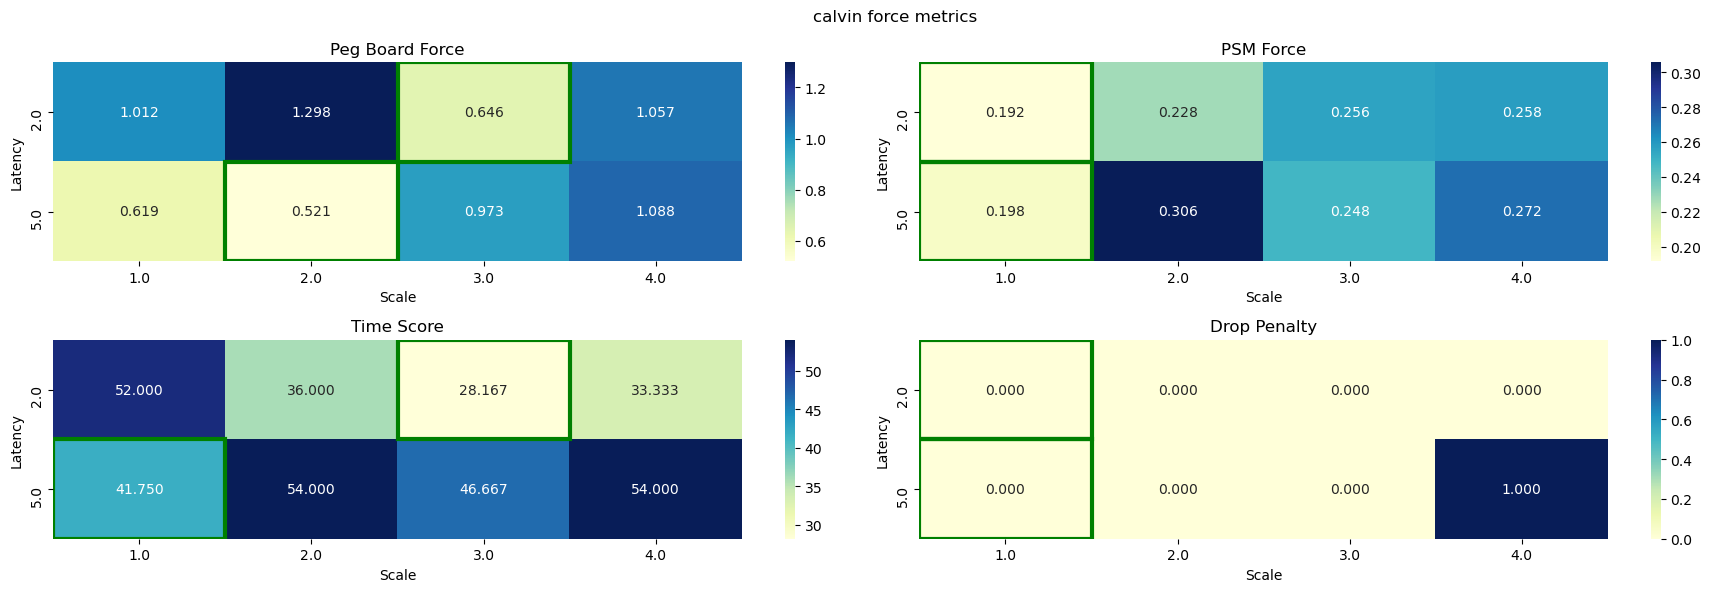

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.597691   0.185918   38.500000           0.0   
1    1.0      5.0     0.995316   0.214580   39.500000           0.0   
2    2.0      2.0     1.429956   0.241011   24.000000           0.0   
3    2.0      5.0     1.131256   0.246808   30.833333           0.0   
4    3.0      2.0     1.313481   0.310391   13.400000           0.0   
5    3.0      5.0     1.315879   0.264231   38.500000           0.0   
6    4.0      2.0     1.160187   0.338763   12.833333           0.0   
7    4.0      5.0     1.378853   0.301066   22.166667           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


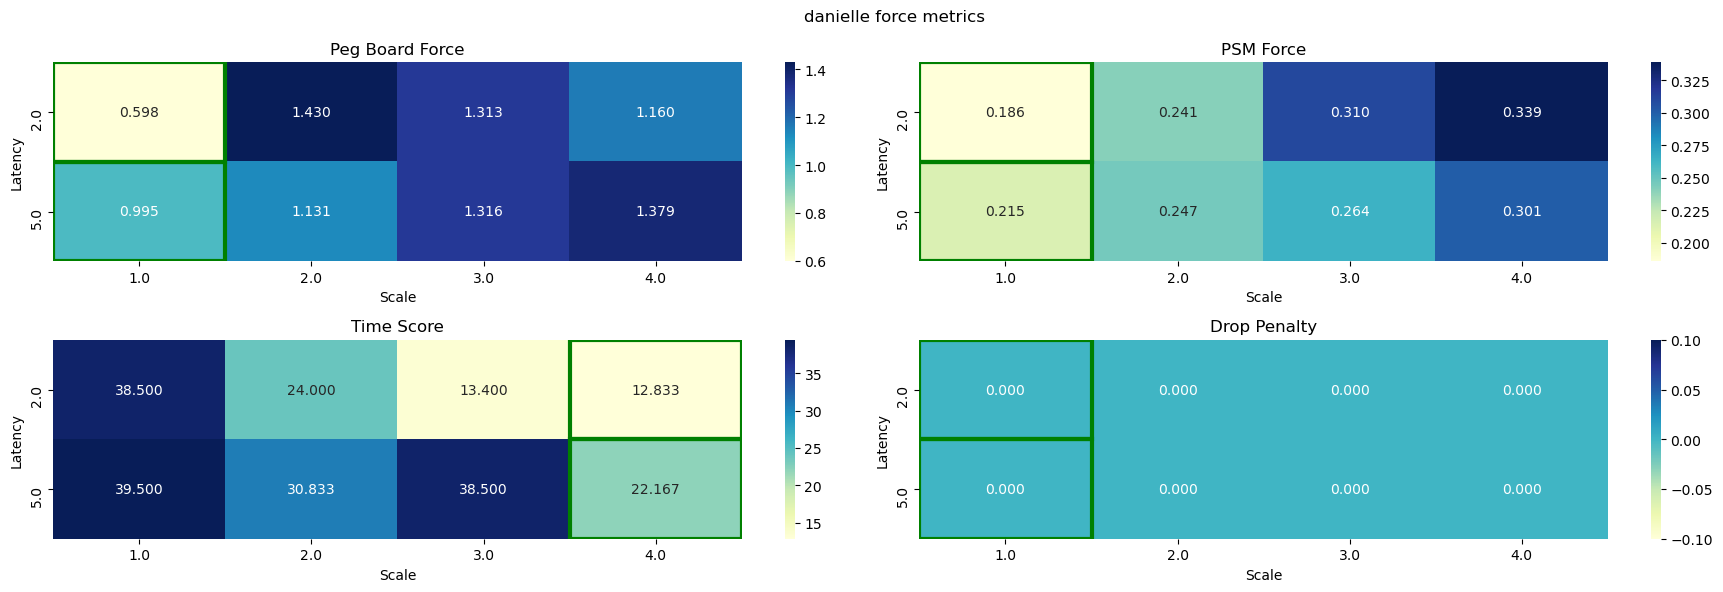

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.718615   0.151746   54.250000           0.0   
1    1.0      5.0     0.692966   0.159354   58.333333           0.0   
2    2.0      2.0     1.258056   0.184584   37.333333           0.0   
3    2.0      5.0     0.570994   0.169941   48.666667           0.0   
4    3.0      2.0     1.049341   0.262755   14.833333           0.0   
5    3.0      5.0     1.104288   0.219001   37.166667           0.0   
6    4.0      2.0     1.151028   0.231147   20.833333           0.0   
7    4.0      5.0     0.786011   0.200870   46.833333           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


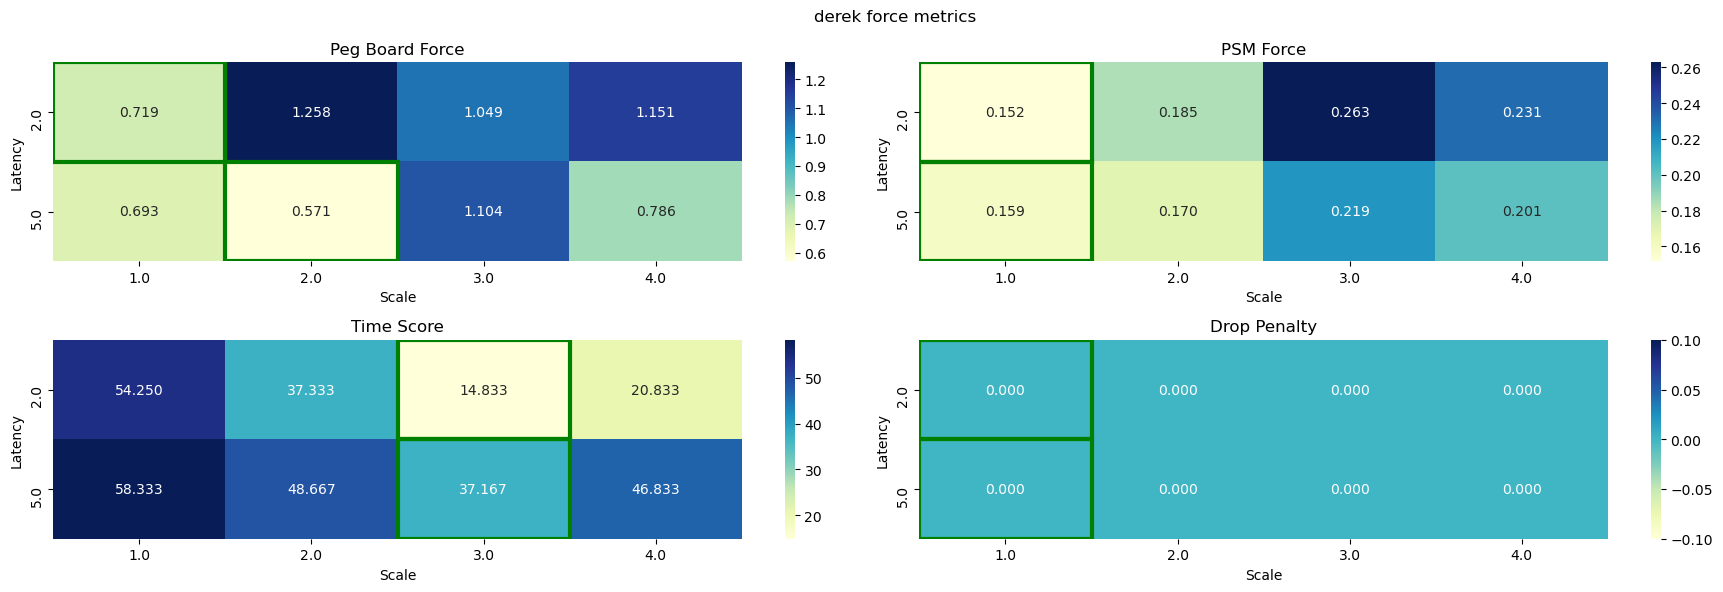

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     1.078591   0.124503   80.750000           0.0   
1    1.0      5.0     0.670567   0.128889   77.666667           0.0   
2    2.0      2.0     0.948935   0.191631   33.400000           0.0   
3    2.0      5.0     1.232375   0.201135   53.833333           0.0   
4    3.0      2.0     0.576346   0.188700   29.500000           0.0   
5    3.0      5.0     0.886559   0.152561   64.200000           0.0   
6    4.0      2.0     0.685180   0.196558   29.333333           0.0   
7    4.0      5.0     1.040547   0.218108   40.666667           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


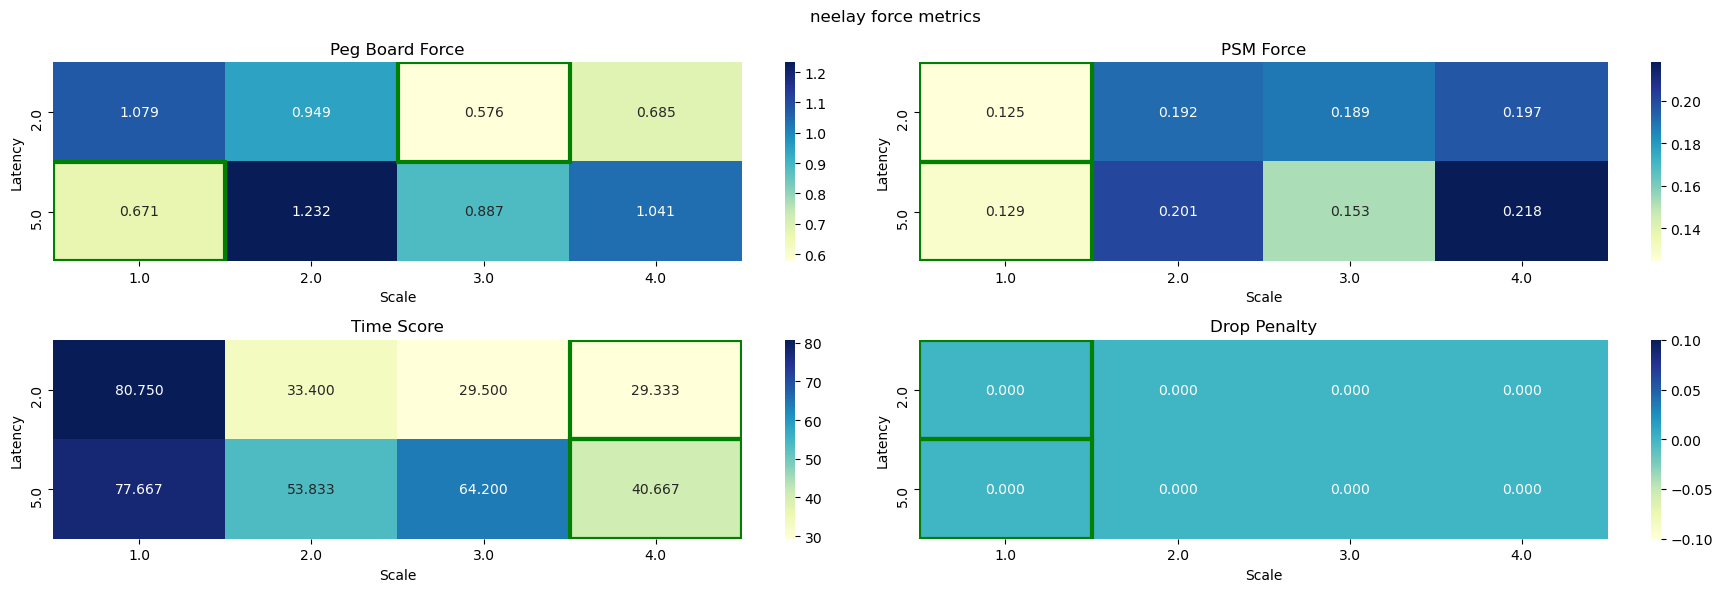

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.714194   0.173867   59.000000           0.0   
1    1.0      5.0     0.606970   0.184507   60.750000           0.0   
2    2.0      2.0     0.919228   0.192932   56.333333           0.0   
3    2.0      5.0     0.863761   0.208828   39.600000           0.0   
4    3.0      2.0     1.303511   0.243568   31.200000           1.0   
5    3.0      5.0     0.718429   0.211340   43.250000           1.0   
6    4.0      2.0     1.036638   0.272797   27.333333           0.0   
7    4.0      5.0     0.799614   0.228926   47.166667           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


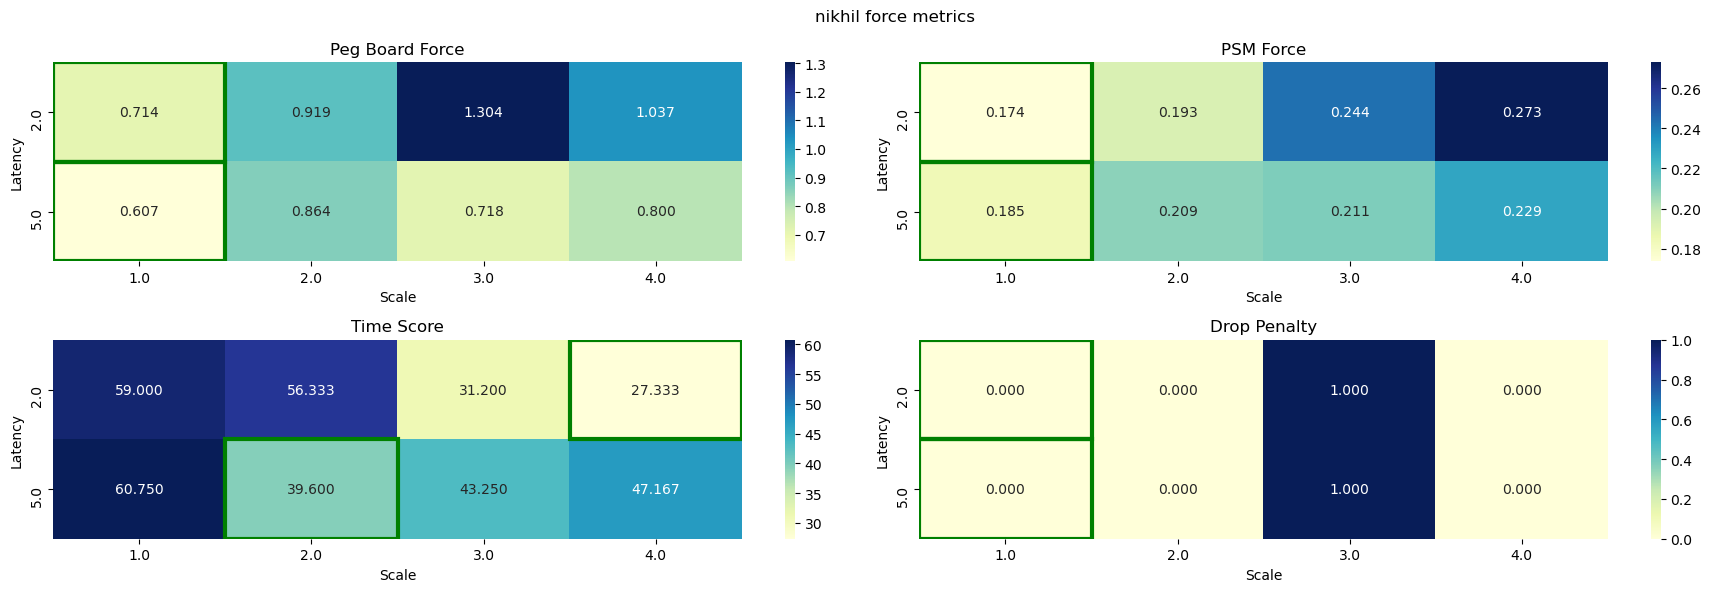

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.842113   0.163867   70.333333           0.0   
1    1.0      5.0     0.625889   0.121839   86.250000           0.0   
2    2.0      2.0     0.940483   0.173822   46.666667           0.0   
3    2.0      5.0     0.863710   0.156968   61.000000           0.0   
4    3.0      2.0     1.054133   0.210571   33.666667           0.0   
5    3.0      5.0     1.755874   0.231886   55.166667           0.0   
6    4.0      2.0     1.231990   0.211537   29.166667           0.0   
7    4.0      5.0     2.738462   0.283623   54.600000           1.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


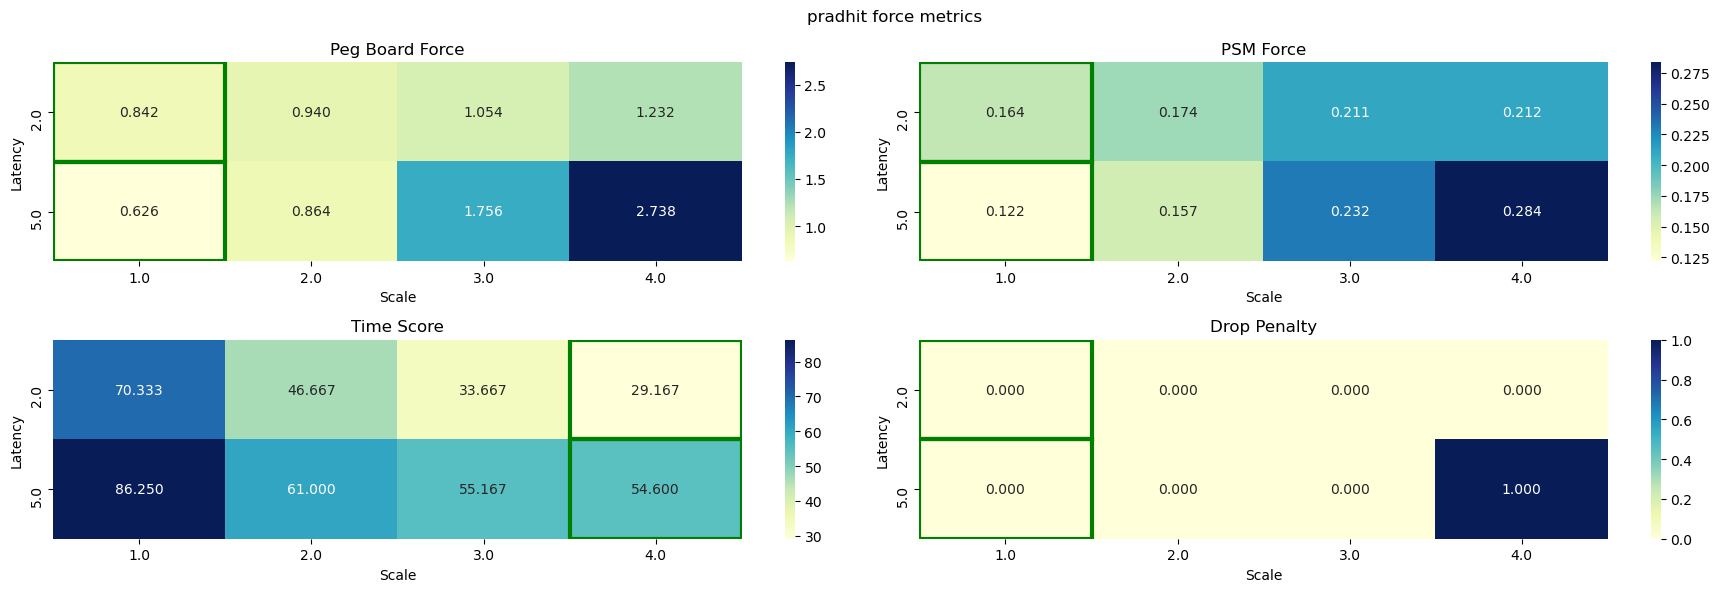

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      5.0     0.549714   0.155527   65.800000           0.0   
1    2.0      2.0     0.761048   0.226455   37.166667           0.0   
2    2.0      5.0     0.912886   0.225051   42.333333           0.0   
3    3.0      2.0     1.507974   0.246457   29.166667           0.0   
4    3.0      5.0     1.744967   0.286552   37.000000           0.0   
5    4.0      2.0     1.720225   0.301390   22.500000           0.0   
6    4.0      5.0     2.101400   0.334261   43.333333           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  


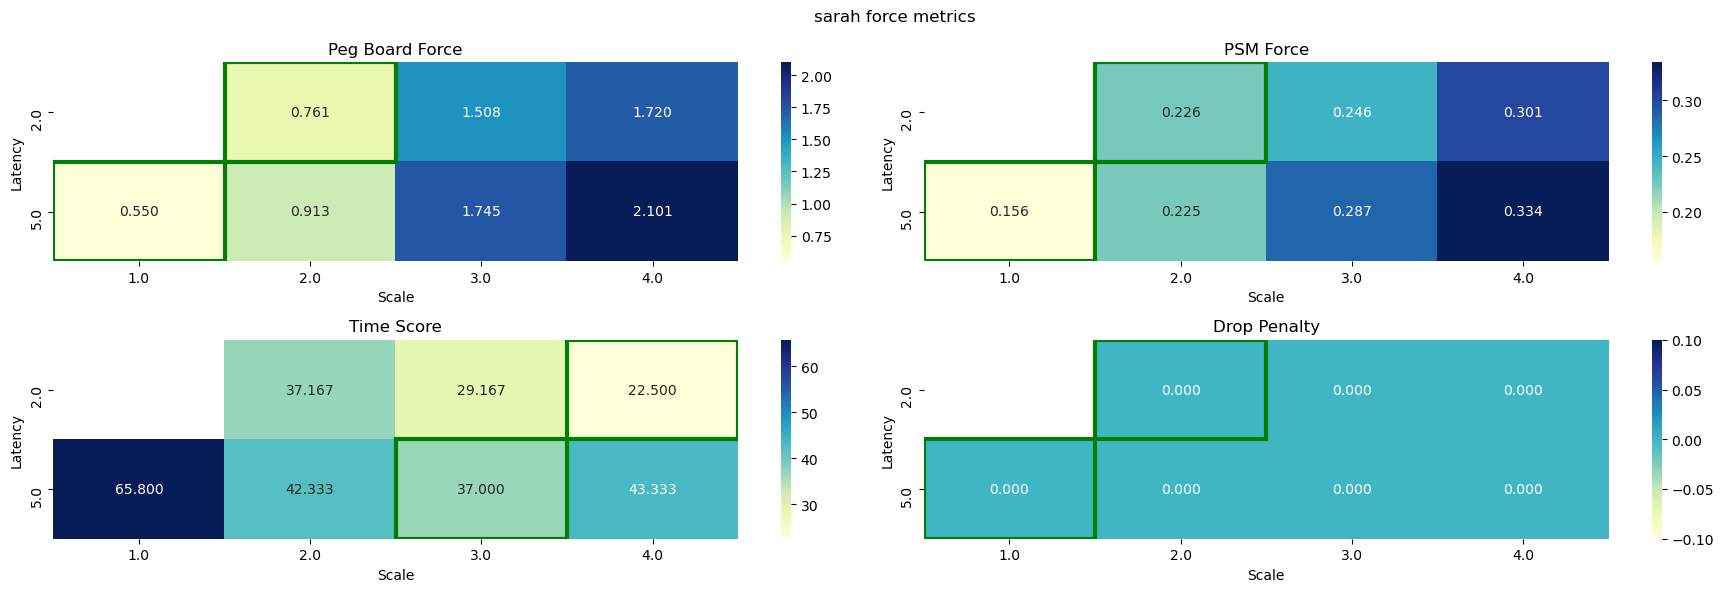

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.597924   0.116524   71.666667           0.0   
1    1.0      5.0     1.261087   0.180126   74.000000           0.0   
2    2.0      2.0     0.726226   0.182598   27.800000           1.0   
3    2.0      5.0     0.668622   0.149972   57.333333           0.0   
4    3.0      2.0     0.892013   0.169618   39.333333           0.0   
5    3.0      5.0     2.295396   0.201663   52.000000           0.0   
6    4.0      2.0     1.670061   0.239628   47.800000           0.0   
7    4.0      5.0     1.545092   0.228147   48.250000           1.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


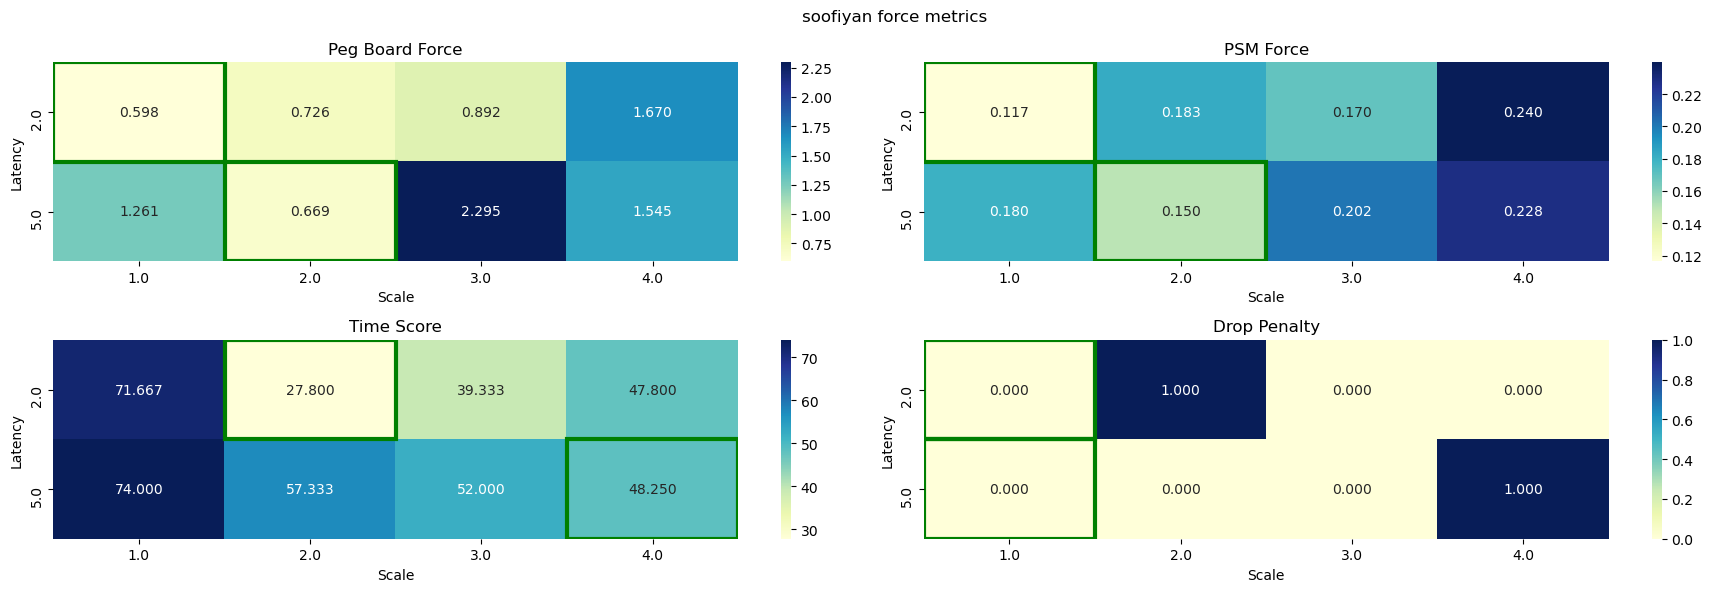

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.237090   0.123702   67.500000           1.0   
1    1.0      5.0     0.492894   0.126761  132.333333           0.0   
2    2.0      2.0     1.062891   0.191925   31.666667           0.0   
3    2.0      5.0     0.713231   0.195116   60.000000           0.0   
4    3.0      2.0     0.413150   0.194104   31.500000           0.0   
5    3.0      5.0     1.097086   0.193216   55.000000           0.0   
6    4.0      2.0     0.707289   0.242073   26.000000           0.0   
7    4.0      5.0     0.531546   0.202612   82.666667           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


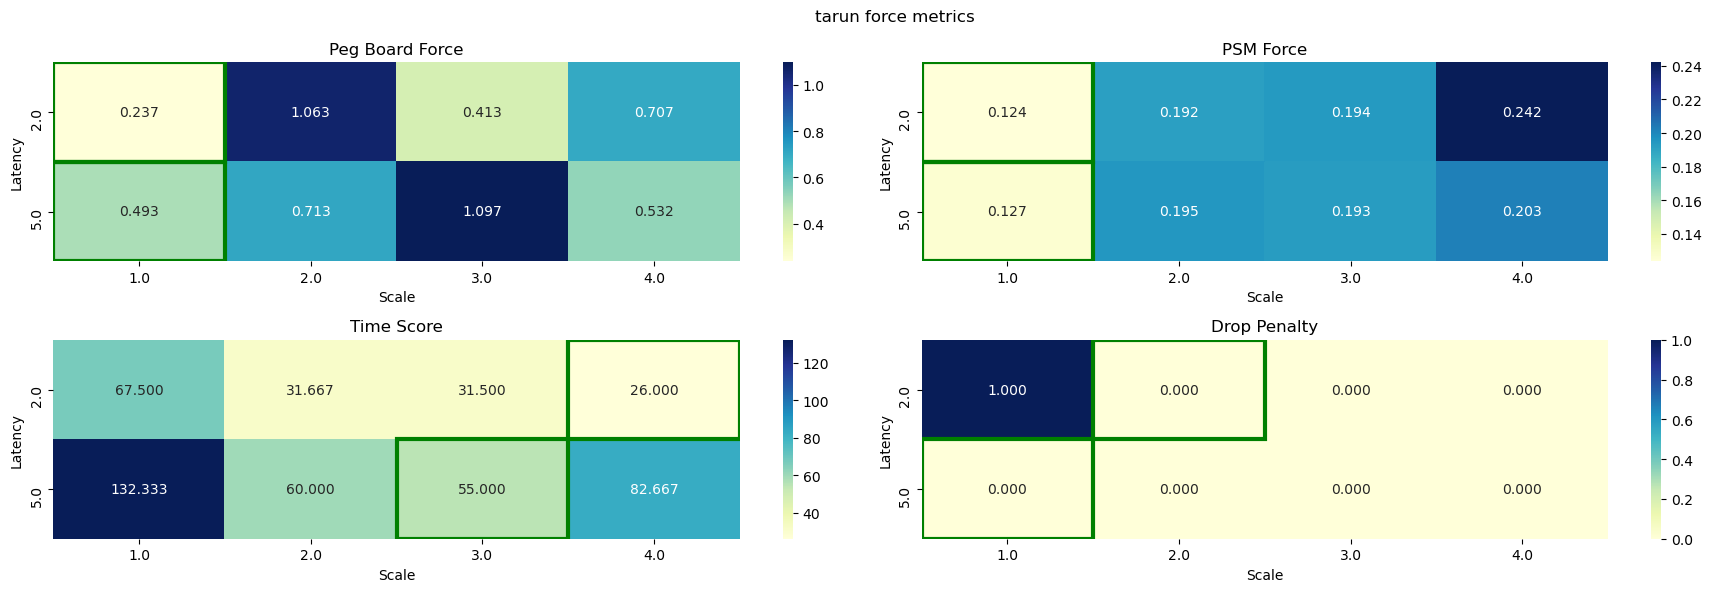

   scale  latency  board_force  psm_force  time_score  drop_penalty  \
0    1.0      2.0     0.588120   0.139375   57.666667           0.0   
1    1.0      5.0     0.809690   0.134609   55.200000           0.0   
2    2.0      2.0     0.945825   0.171365   37.666667           0.0   
3    2.0      5.0     0.939090   0.173477   34.250000           0.0   
4    3.0      2.0     1.187922   0.228557   24.000000           0.0   
5    3.0      5.0     0.850434   0.213360   38.000000           0.0   
6    4.0      2.0     0.875042   0.230673   28.833333           0.0   
7    4.0      5.0     1.101850   0.213940   39.333333           0.0   

   overall_score  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6            0.0  
7            0.0  


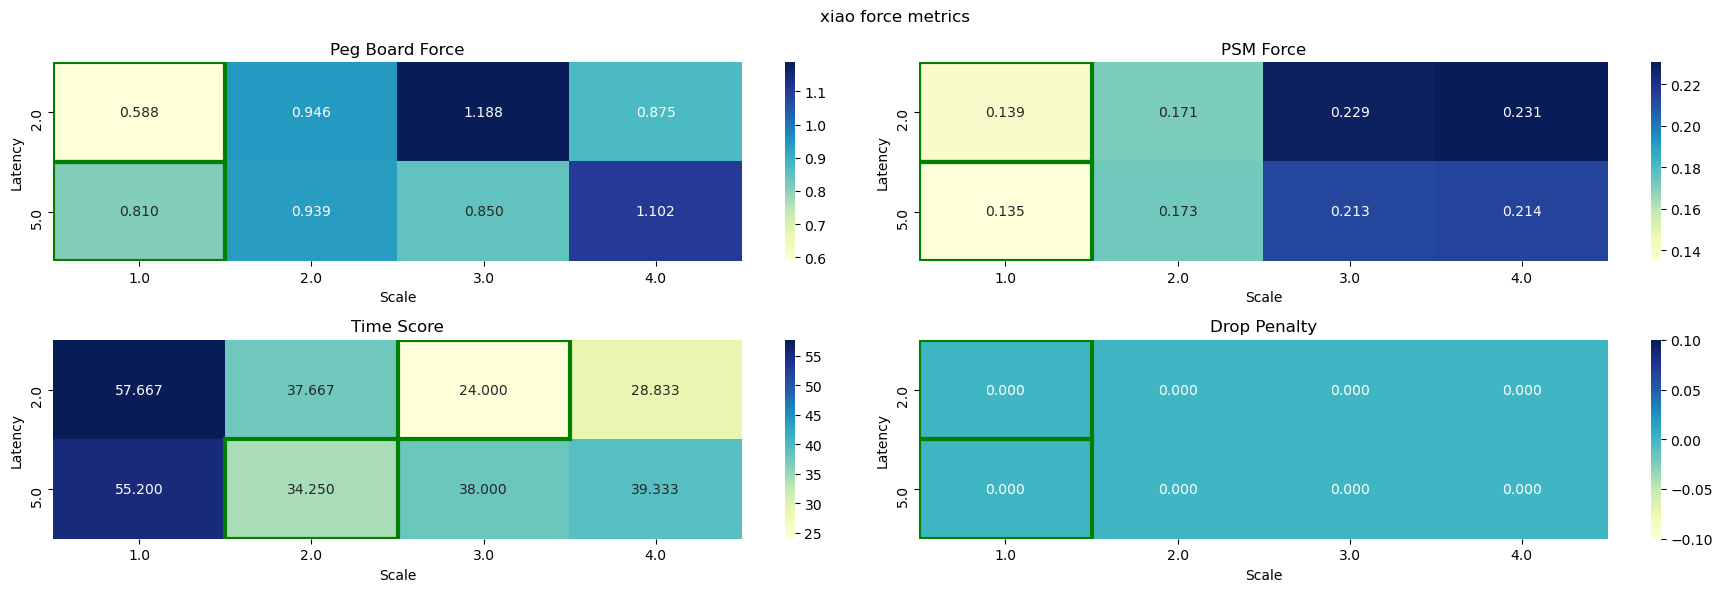

In [18]:
import seaborn as sns

# Function to add red border to maximum value in each row
def annotate_extrema(data, ax, extrema_type='max'):
    if extrema_type == 'max':
        extrema_index = np.nanargmax(data, axis=1)
        color = 'red'
    if extrema_type == 'min':
        extrema_index = np.nanargmin(data, axis=1)
        color = 'green'
    for i, max_col in enumerate(extrema_index):
        ax.add_patch(plt.Rectangle((max_col, i), 1, 1, fill=False, edgecolor=color, lw=3))

for user, metric_data in all_user_data.items():
	print(metric_data)
	fig, ax = plt.subplots(2, 2, figsize=(18, 6))
	title = (f"{user} force metrics")
	fig.suptitle(title)
	board_force_heatmap = metric_data.pivot(
		index='latency', columns='scale', values='board_force'
	)
	sns.heatmap(board_force_heatmap, cmap='YlGnBu', ax=ax[0, 0], annot=True, fmt='.3f')
	ax[0, 0].set_title('Peg Board Force')
	ax[0, 0].set_xlabel('Scale')
	ax[0, 0].set_ylabel('Latency')
	annotate_extrema(board_force_heatmap.values, ax[0, 0], extrema_type='min')

	psm_force_heatmap = metric_data.pivot(
		index='latency', columns='scale', values='psm_force'
	)
	sns.heatmap(psm_force_heatmap, cmap='YlGnBu', ax=ax[0, 1], annot=True, fmt='.3f')
	ax[0, 1].set_title('PSM Force')
	ax[0, 1].set_xlabel('Scale')
	ax[0, 1].set_ylabel('Latency')
	annotate_extrema(psm_force_heatmap.values, ax[0, 1], extrema_type='min')

	time_score_heatmap = metric_data.pivot(
		index='latency', columns='scale', values='time_score'
	)
	sns.heatmap(time_score_heatmap, cmap='YlGnBu', ax=ax[1, 0], annot=True, fmt='.3f')
	ax[1, 0].set_title('Time Score')
	ax[1, 0].set_xlabel('Scale')
	ax[1, 0].set_ylabel('Latency')
	annotate_extrema(time_score_heatmap.values, ax[1, 0], extrema_type='min')

	drop_penalty_heatmap = metric_data.pivot(
		index='latency', columns='scale', values='drop_penalty'
	)
	sns.heatmap(drop_penalty_heatmap, cmap='YlGnBu', ax=ax[1, 1], annot=True, fmt='.3f')
	ax[1, 1].set_title('Drop Penalty')
	ax[1, 1].set_xlabel('Scale')
	ax[1, 1].set_ylabel('Latency')
	annotate_extrema(drop_penalty_heatmap.values, ax[1, 1], extrema_type='min')

	plt.tight_layout()
	folder = "../figures/dvrk"
	os.makedirs(folder, exist_ok=True)
	filepath = f"{folder}/{user}_metrics_summed.png"
	plt.savefig(filepath, facecolor='w')
	plt.show()

	# # Calculate average board_force and psm_force across scale for latency 2 and 5
	# force_avgs['delay2'].append(metric_data[metric_data['latency'] == 2].mean()['board_force'])
	# force_avgs['delay5'].append(metric_data[metric_data['latency'] == 5].mean()['board_force'])

	

# # Plot average board force across scale for each user
# plt.figure(figsize=(10, 6))
# for data in all_user_data:
# 	scales = data['scale'].unique()
# 	forces = data[data['latency'] == 5]['board_force']
# 	plt.plot(scales, forces, marker='o')

# plt.legend([f"User {i}" for i in range(len(user_list))])
# plt.xlabel('Scale')
# plt.ylabel('Average Force')
# plt.title('Safety vs. Scale (Latency = .5 s)')
# plt.grid(True)
# plt.show()
# # plt.figure()
# # for data in all_user_data:
# # 	scales = data['scale'].unique()
# # 	forces = data[data['latency'] == 5]['board_force']
# # 	plt.plot(scales, forces)

# # plt.legend([f"User {i}" for i in range(len(user_list))])
# # plt.show()

# # Plot time score vs. scale for each user
# plt.figure(figsize=(10, 6))
# for data in all_user_data:
# 	scales = data['scale'].unique()
# 	time_scores = data[data['latency'] == 5]['time_score']
# 	plt.plot(scales, time_scores, marker='o')
# plt.legend([f"User {i}" for i in range(len(user_list))])
# plt.xlabel('Scale')
# plt.ylabel('Time Score')
# plt.title('Time Score vs. Scale (Latency = .5 s)')
# plt.grid(True)
# plt.show()


# Calculate aggregate metrics/statistics for all users

In [3]:
# Calculate and plot the average metrics across users in all_user_data
avg_data = pd.DataFrame(columns=["scale", "latency"] + metrics)
for s, d in itertools.product(scale_domain, delay_domain):
	avg_data.loc[len(avg_data)] = [s, d] + [np.mean([data[(data['scale'] == s) & (data['latency'] == d)][metric].values[0] for data in all_user_data.values()]) for metric in metrics]

	fig, ax = plt.subplots(2, 2, figsize=(18, 6))
	fig.suptitle("Average Metrics Across Users")

	board_force_heatmap = avg_data.pivot(index='latency', columns='scale', values='board_force')
	sns.heatmap(board_force_heatmap, cmap='YlGnBu', ax=ax[0, 0], annot=True, fmt='.3f')
	ax[0, 0].set_title('Average Peg Board Force')
	ax[0, 0].set_xlabel('Scale')
	ax[0, 0].set_ylabel('Latency')
	annotate_extrema(board_force_heatmap.values, ax[0, 0], extrema_type='min')

	psm_force_heatmap = avg_data.pivot(index='latency', columns='scale', values='psm_force')
	sns.heatmap(psm_force_heatmap, cmap='YlGnBu', ax=ax[0, 1], annot=True, fmt='.3f')
	ax[0, 1].set_title('Average PSM Force')
	ax[0, 1].set_xlabel('Scale')
	ax[0, 1].set_ylabel('Latency')
	annotate_extrema(psm_force_heatmap.values, ax[0, 1], extrema_type='min')

	time_score_heatmap = avg_data.pivot(index='latency', columns='scale', values='time_score')
	sns.heatmap(time_score_heatmap, cmap='YlGnBu', ax=ax[1, 0], annot=True, fmt='.3f')
	ax[1, 0].set_title('Average Time Score')
	ax[1, 0].set_xlabel('Scale')
	ax[1, 0].set_ylabel('Latency')
	annotate_extrema(time_score_heatmap.values, ax[1, 0], extrema_type='min')

	drop_penalty_heatmap = avg_data.pivot(index='latency', columns='scale', values='drop_penalty')
	sns.heatmap(drop_penalty_heatmap, cmap='YlGnBu', ax=ax[1, 1], annot=True, fmt='.3f')
	ax[1, 1].set_title('Average Drop Penalty')
	ax[1, 1].set_xlabel('Scale')
	ax[1, 1].set_ylabel('Latency')
	annotate_extrema(drop_penalty_heatmap.values, ax[1, 1], extrema_type='min')

	plt.tight_layout()
	plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import pandas as pd
import numpy as np

def clock_to_sec(clock_time:str):
	'''
	Converts from a time in format string "hours:minutes:seconds" to an integer in seconds

	Args:
		clock_time (string)

	Returns:
		seconds (int)
	'''
	split_str = reversed(clock_time.split(':'))
	seconds = 0
	for i, s in enumerate(split_str):
		seconds += float(s)*60**(i)

	return seconds

# Create a test dataframe with a time column in format "hours:minutes:seconds"
# data = {'freeze_intervals': ["(1:58,2:38),(3:05,3:45)"]}
# df = pd.DataFrame(data)
# df = df.loc[0]
# print(df)
# intervals_str = df["freeze_intervals"]
# rosbag_start_time = 5
# start_time = 34 - rosbag_start_time
# end_time = clock_to_sec("6:02") - rosbag_start_time
# # print(intervals_str)
# # intervals = intervals_str.strip('()').split('),(')
# # intervals = [(clock_to_sec(start), clock_to_sec(end)) for start, end in (interval.split(',') for interval in intervals)]
# # print(intervals)
# # rosbag_start_time = 5
# # intervals = [(start - rosbag_start_time, end - rosbag_start_time) for start, end in intervals]
# # print(intervals)

# # Compute intervals of psm/fts data to keep
# # intervals_str = cur_video_data["freeze_intervals"]
# if intervals_str == "0": # no freezes
# 	keep_intervals = [(start_time, end_time)]
# else:
# 	intervals = intervals_str.strip('()').split('),(')
# 	intervals = [(clock_to_sec(start), clock_to_sec(end)) for start, end in (interval.split(',') for interval in intervals)]
# 	freeze_intervals = [(start - rosbag_start_time, end - rosbag_start_time) for start, end in intervals]
# 	remove_intervals = [(0, start_time)] + freeze_intervals + [(end_time, end_time)]
# 	remove_intervals.
# 	for interval in freeze_intervals:
# 		keep_intervals.append((freeze_intervals[i][1], freeze_intervals[i+1][0]))
# 	keep_intervals.append((freeze_intervals[-1][1], end_time))
# print(keep_intervals)

# test clipping of fts data
data = np.arange(0, 11, 1)
fts_data = pd.DataFrame(data, columns=[' Time '])
print(fts_data)
intervals = [(2, 4), (6, 8)]
start_time = 1
end_time = 9

fts_start_idx = fts_data[' Time '].sub(start_time).abs().idxmin()
fts_end_idx = fts_data[' Time '].sub(end_time).abs().idxmin()
fts_data_clip = fts_data.loc[fts_start_idx:fts_end_idx].copy()
print(fts_data_clip)

# Remove the portions of fts_data_clip given by intervals
for interval in intervals:
	fts_data_clip = fts_data_clip[(fts_data_clip[' Time '] < interval[0]) | (fts_data_clip[' Time '] > interval[1])]

print(fts_data_clip)


In [ ]:
x = [(1, 2), (3, 4), (5, 6)]
y = [(0, 1)] + x + [(7, 8)]
print(y)

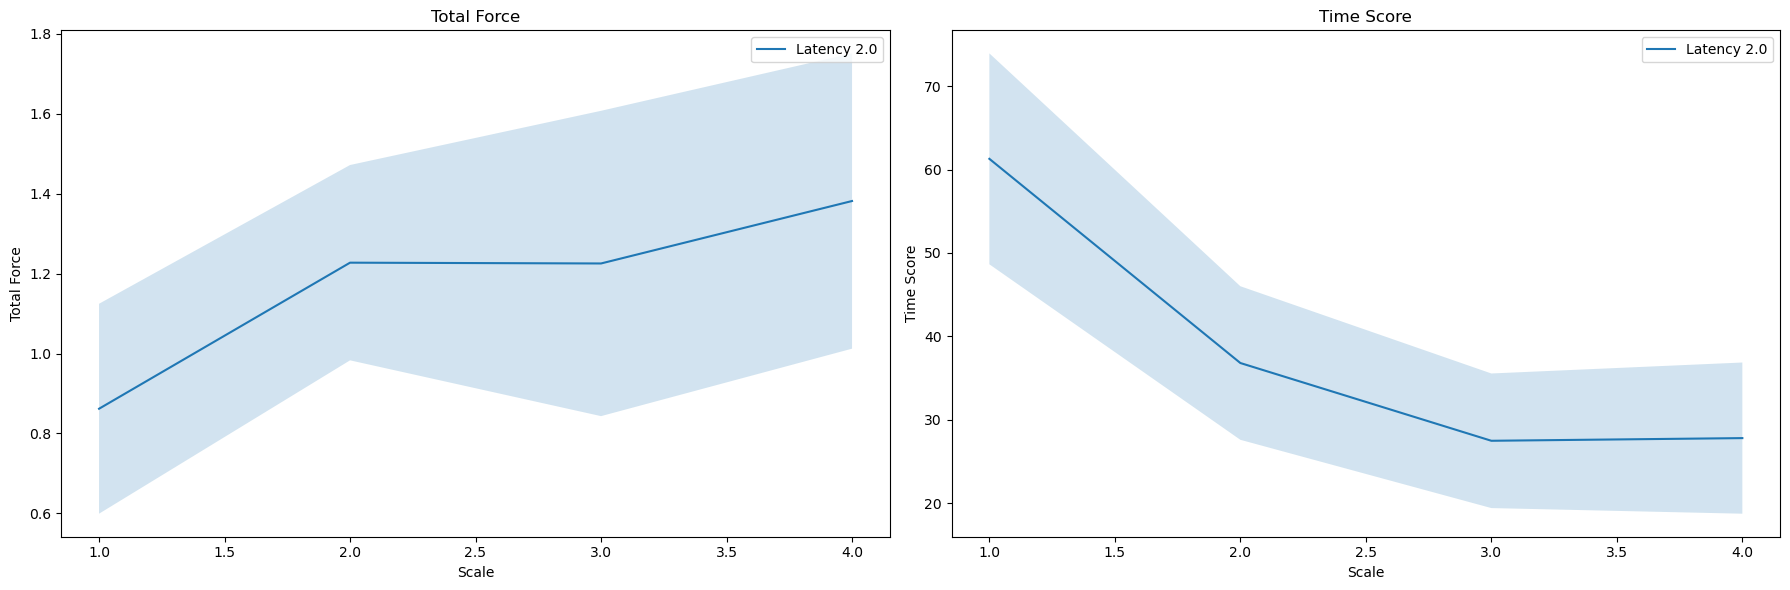

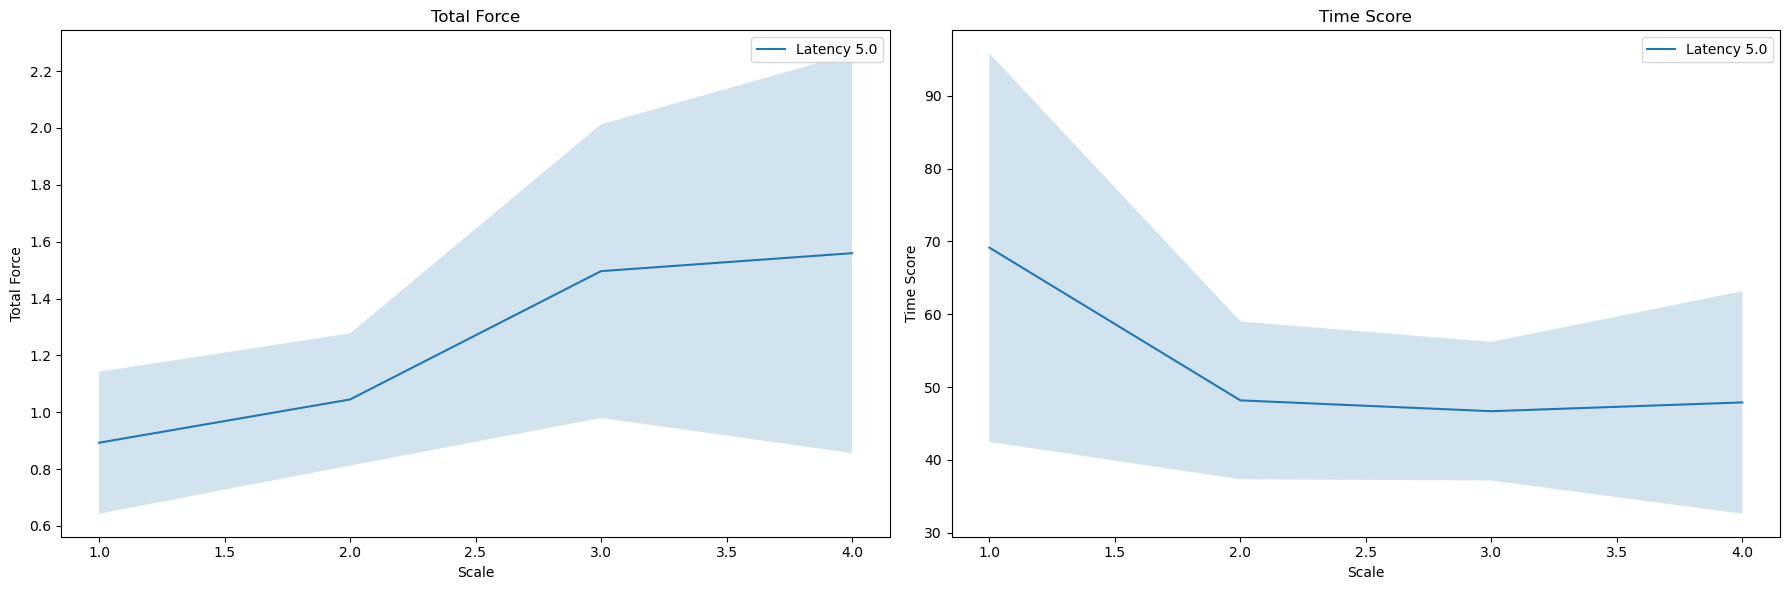

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming all_user_data is already populated with user data
# Example structure of all_user_data:
# all_user_data = {
#     "user1": pd.DataFrame(...),
#     "user2": pd.DataFrame(...),
#     ...
# }

# Combine all user data into a single DataFrame
combined_data = pd.concat(all_user_data.values(), keys=all_user_data.keys(), names=['user', 'index'])

# Add a new column for the sum of board_force and psm_force
combined_data['total_force'] = combined_data['board_force'] + combined_data['psm_force']

# Group by scale and latency, then calculate mean and standard deviation
grouped_data = combined_data.groupby(['scale', 'latency']).agg(['mean', 'std']).reset_index()
scales = grouped_data['scale']
latencies = grouped_data['latency']
for latency in latencies.unique():
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # metrics = ["board_force", "psm_force", "time_score"]
    # titles = ["Board Force", "PSM Force", "Time Score"]
    metrics = ["total_force", "time_score"]
    titles = ["Total Force", "Time Score"]

    for i, metric in enumerate(metrics):
        mean_values = grouped_data[(metric, 'mean')]
        std_values = grouped_data[(metric, 'std')]
        

        
        latency_mask = latencies == latency
        axs[i].plot(scales[latency_mask], mean_values[latency_mask], label=f'Latency {latency}')
        axs[i].fill_between(scales[latency_mask], 
                            mean_values[latency_mask] - std_values[latency_mask], 
                            mean_values[latency_mask] + std_values[latency_mask], 
                            alpha=0.2)

        axs[i].set_title(titles[i])
        axs[i].set_xlabel('Scale')
        axs[i].set_ylabel(metric.replace('_', ' ').title())
        axs[i].legend()

    plt.tight_layout()
    plt.show()

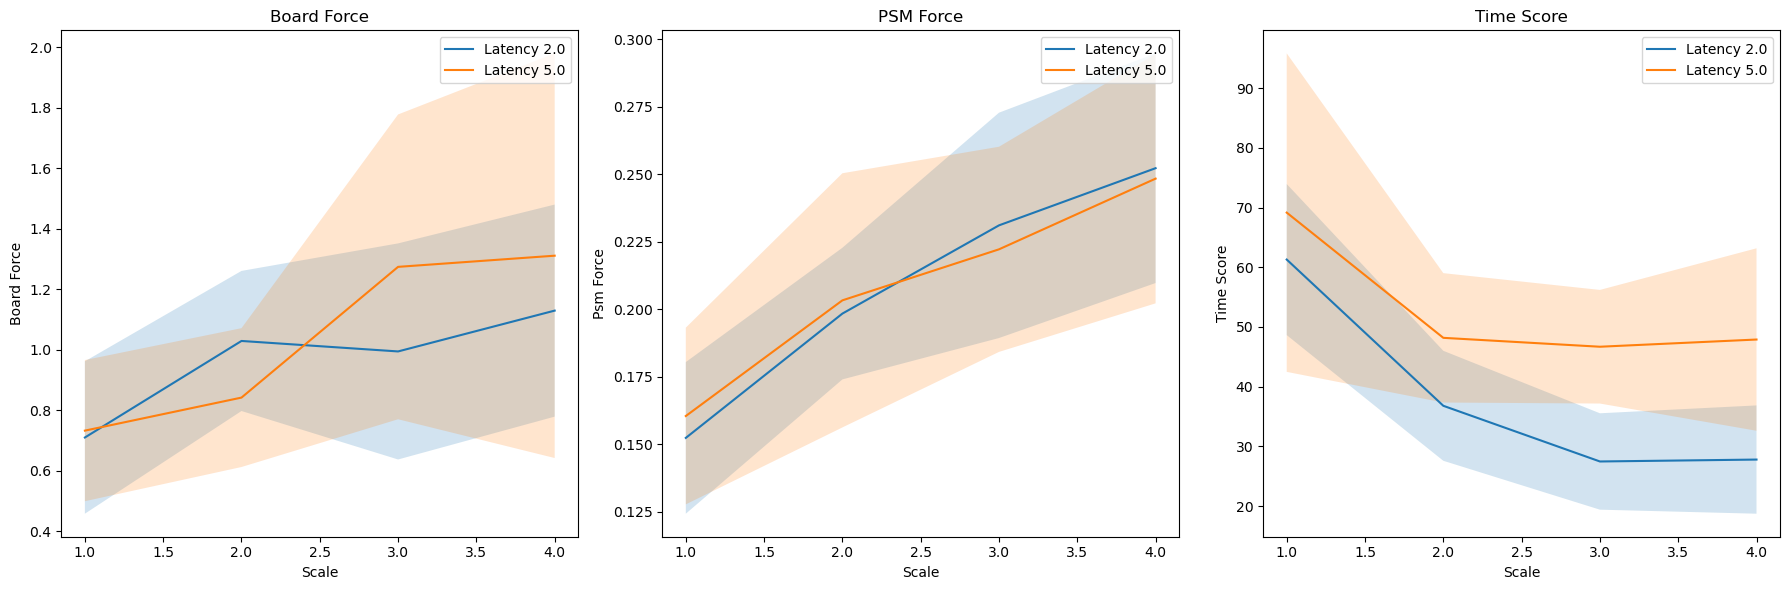

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming all_user_data is already populated with user data
# Example structure of all_user_data:
# all_user_data = {
#     "user1": pd.DataFrame(...),
#     "user2": pd.DataFrame(...),
#     ...
# }

# Combine all user data into a single DataFrame
combined_data = pd.concat(all_user_data.values(), keys=all_user_data.keys(), names=['user', 'index'])

# Add a new column for the sum of board_force and psm_force
combined_data['total_force'] = combined_data['board_force'] + combined_data['psm_force']

# Group by scale and latency, then calculate mean and standard deviation
grouped_data = combined_data.groupby(['scale', 'latency']).agg(['mean', 'std']).reset_index()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
metrics = ["board_force", "psm_force", "time_score"]
titles = ["Board Force", "PSM Force", "Time Score"]

for i, metric in enumerate(metrics):
    mean_values = grouped_data[(metric, 'mean')]
    std_values = grouped_data[(metric, 'std')]
    scales = grouped_data['scale']
    latencies = grouped_data['latency']

    for latency in latencies.unique():
        latency_mask = latencies == latency
        axs[i].plot(scales[latency_mask], mean_values[latency_mask], label=f'Latency {latency}')
        axs[i].fill_between(scales[latency_mask], 
                            mean_values[latency_mask] - std_values[latency_mask], 
                            mean_values[latency_mask] + std_values[latency_mask], 
                            alpha=0.2)

    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Scale')
    axs[i].set_ylabel(metric.replace('_', ' ').title())
    axs[i].legend()

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Assuming all_user_data is already populated with user data
# Example structure of all_user_data:
# all_user_data = {
#     "user1": pd.DataFrame(...),
#     "user2": pd.DataFrame(...),
#     ...
# }

# Combine all user data into a single DataFrame
combined_data = pd.concat(all_user_data.values(), keys=all_user_data.keys(), names=['user', 'index'])

# Add a new column for the sum of board_force and psm_force
combined_data['total_force'] = combined_data['board_force'] + combined_data['psm_force']

# Calculate the average for each metric for each user
user_averages = combined_data.groupby('user').mean()

# Sort users by their average values for each metric
sorted_total_force = user_averages['total_force'].sort_values(ascending=False)
sorted_time_score = user_averages['time_score'].sort_values(ascending=False)

# Print the results
print("User averages for total_force from highest to lowest:")
print(sorted_total_force)

print("\nUser averages for time_score from highest to lowest:")
print(sorted_time_score)

# If you want to print each user and their averages separately
print("\nDetailed user averages for total_force:")
for user, value in sorted_total_force.items():
    print(f"User: {user}, Total Force: {value:.2f}")

print("\nDetailed user averages for time_score:")
for user, value in sorted_time_score.items():
    print(f"User: {user}, Time Score: {value:.2f}")

User averages for total_force from highest to lowest:
user
danielle    0.683995
sarah       0.661736
pradhit     0.624298
soofiyan    0.516988
derek       0.481745
calvin      0.471831
neelay      0.457371
xiao        0.426479
nikhil      0.398841
tarun       0.308201
Name: total_force, dtype: float64

User averages for time_score from highest to lowest:
user
tarun       60.833333
pradhit     54.606250
soofiyan    52.272917
neelay      51.168750
nikhil      45.579167
calvin      43.239583
derek       39.781250
sarah       39.614286
xiao        39.368750
danielle    27.466667
Name: time_score, dtype: float64

Detailed user averages for total_force:
User: danielle, Total Force: 0.68
User: sarah, Total Force: 0.66
User: pradhit, Total Force: 0.62
User: soofiyan, Total Force: 0.52
User: derek, Total Force: 0.48
User: calvin, Total Force: 0.47
User: neelay, Total Force: 0.46
User: xiao, Total Force: 0.43
User: nikhil, Total Force: 0.40
User: tarun, Total Force: 0.31

Detailed user averages 